# DeepNN for Sink Particles
> Created Oct. 2024 <br>
> Nikhil Bisht<br>

In [2]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn


# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [5]:
DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/final_88/nb101_ML_dataset.csv'
MODELFILE = 'nnmodel.dict'

NTRAIN = 1600000
NVALID =  100000
NTEST  =  300000 #roughly

TARGET = ['O_Clump_X', 'O_Clump_Y',	'O_Clump_Z', 'O_Clump_Vx', 'O_Clump_Vy', 'O_Clump_Vz', 'O_Clump_density','O_t_end']
FEATURES = ['X', 'Y', 'Z', 'Density', 'Vx', 'Vy', 'Vz', 't_hard']

n_input = len(FEATURES)
n_output = len(TARGET)

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')
print(n_input, n_output)

Available device: cpu 
8 8


## Load data

In [6]:
df = pd.read_csv(DATAFILE)
print(len(df))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

2097152


,Unnamed: 0,Clump_id,Particle_id,X,Y,Z,Density,Vx,Vy,Vz,t_hard,O_Clump_X,O_Clump_Y,O_Clump_Z,O_Clump_Vx,O_Clump_Vy,O_Clump_Vz,O_Clump_density,O_t_end
0,521024,-1,820136.0,0.831301,0.083967,0.543035,0.130214,1.288411,-0.172561,-3.757433,0.403104,0.848675,0.084979,0.500263,3.361485,0.782921,-4.834196,0.102839,0.66003
1,207748,-1,282394.0,0.583104,0.967716,0.689215,0.981035,-3.306590,-5.409646,4.655127,0.403104,0.554212,0.896940,0.725584,-1.906034,-8.132756,1.442962,9.925290,0.66003
2,1936511,-1,879987.0,0.994669,0.469619,0.640182,2.326365,3.020340,2.136101,-0.477079,0.403104,0.026150,0.487994,0.630964,3.136618,1.206108,-0.939501,2.143641,0.66003
3,725476,-1,945326.0,0.089112,0.428726,0.756449,1.446005,9.710651,-0.711959,-1.795781,0.403104,0.159908,0.421254,0.740063,4.140229,0.880568,-1.270677,6.412669,0.66003
4,1165564,-1,1812977.0,0.340104,0.786708,0.404211,0.533340,-2.804477,-2.575938,-1.472766,0.403104,0.311318,0.777068,0.380581,-3.102733,-1.300254,-2.510533,0.484962,0.66003


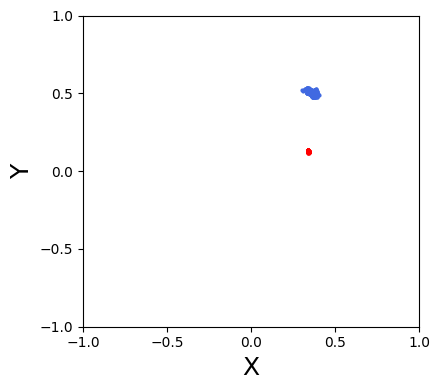

In [7]:
def plot_data():
    
    fig = plt.figure(figsize=(4.5, 4))
    
    ax  = fig.add_subplot(111)
    
    tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    ax.set_xlim(0, 1)
    ax.set_xlabel('X', fontsize=18)
    ax.set_xticks(tickmarks)
    
    ax.set_ylim(0, 1)
    ax.set_ylabel('Y', fontsize=18)
    ax.set_yticks(tickmarks)
    
    d1 = df[df.Clump_id ==2]
    xp, yp = d1.X[:1000], d1.Y[:1000]
    ax.scatter(xp, yp, s=4.0, color='red')
    
    d2 = df[df.Clump_id ==31]
    xp, yp = d2.X[:1000], d2.Y[:1000]
    ax.scatter(xp, yp, s=4.0, color='royalblue');
    
    fig.tight_layout()
    
    plt.show()

plot_data()

## Split data

In [8]:
train_data  = df[:NTRAIN]
print(len(train_data))

valid_data  = df[NTRAIN:NTRAIN+NVALID]
print(len(valid_data))

test_data = df[NTRAIN+NVALID:]
print(len(test_data))

1600000
100000
397152


## Convert to tensors

In [9]:
def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

train_x, train_y = dataframe2tensor(train_data, TARGET, FEATURES)
valid_x, valid_y = dataframe2tensor(valid_data, TARGET, FEATURES)
test_x,  test_y  = dataframe2tensor(test_data,  TARGET, FEATURES)

train_x.shape, train_y.shape

(torch.Size([1600000, 8]), torch.Size([1600000, 8]))

## Some ML Utilities

In [10]:
def get_batch(x, y, batch_size, ii):
    # cycle through batches of training data sequentially
    K = int(len(x) / batch_size + 0.5) # number of batches / epoch
    jj = ii % K
    start = jj * batch_size
    end = start + batch_size - 1
    if end > len(x)-1:
        end = len(x)-1
    return x[start: end+1], y[start: end+1], jj

def get_random_batch(x, y, batch_size):
    # selects at random "batch_size" integers from 
    # the range [0, batch_size-1] corresponding to the
    # row indices of the training data
    rows = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[rows], y[rows]
        
def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 3.8))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations')
    ax.set_ylabel('average loss')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    plt.show()

## Define the fully-connected neural network

### $\texttt{ReLU}(x)$

$$\text{Relu}(x) = max(0, z)$$


### LayerNorm

$$y = \frac{(x - E[x])}{\sqrt{V(x)}},$$

where the averaging is over the layer.

In [76]:
n_output

8

In [14]:
%%writefile nnmodel.py
import torch.nn as nn
H = 4
n_input = 8
n_output = 8
model = nn.Sequential(nn.Linear(n_input, H), nn.ReLU(), nn.BatchNorm1d(H), nn.Dropout(0.2),
                      nn.Linear(H, int(H/2)), nn.ReLU(),
                      nn.Linear(int(H/2), n_output))


Overwriting nnmodel.py


## Train model

In [15]:
from nnmodel import model

learning_rate = 1.e-4
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

n_iterations  = 25000
n_batch  = 32
n_step   = 10
n_epochs = 1
n_valid  = len(valid_x)
train_x2 = train_x[:n_valid]
train_y2 = train_y[:n_valid]

emprisk  = nn.HuberLoss(delta=0.0005)
print(number_of_parameters(model))
model

78


Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=8, bias=True)
)

|        1|    24990|7.548e-02|7.112e-02|


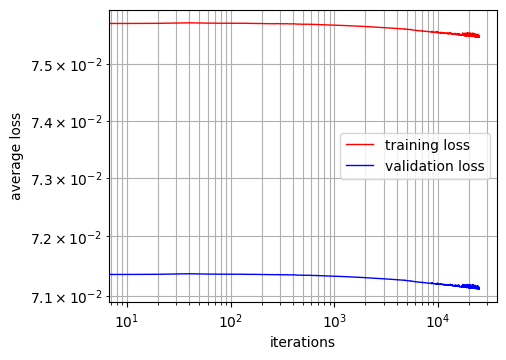

In [16]:
USE_SEQUENTIAL_BATCHES = True

epoch = 0

X = []
T = []
V = []

min_avloss = float('inf')

while epoch<n_epochs:
    for ii in range(n_iterations):

        # clear previous gradients
        
        optimizer.zero_grad()
        
        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        
        model.train()

        # get a batch of data 

        if USE_SEQUENTIAL_BATCHES:
            x, y, jj = get_batch(train_x, train_y, n_batch, ii)
            if jj == 0:
                epoch += 1
        else:
            x, y = get_random_batch(train_x, train_y, n_batch)  
        
        f = model(x).reshape(y.shape)

        R = emprisk(f, y)
        
        R.backward()  # compute gradients of with respect to NN parameters

        optimizer.step()    # advance one step in the space of NN parameters

        if ii % n_step == 0:
            
            t_loss = validate(model, emprisk, train_x2, train_y2).detach()
            v_loss = validate(model, emprisk, valid_x,  valid_y).detach()

            print(f'\r|{epoch:9d}|{ii:9d}|{t_loss:9.3e}|{v_loss:9.3e}|', end='')

            X.append(ii)
            T.append(float(t_loss))
            V.append(float(v_loss))

            if v_loss < 0.995 * min_avloss:
                min_avloss = v_loss
                torch.save(model.state_dict(), MODELFILE)
            
    print()

plot_loss_curve([X, T, V])

# TEST

In [19]:
from nnmodel import model

model.load_state_dict(torch.load(MODELFILE, weights_only=True))

model

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=8, bias=True)
)

In [21]:
# standard measures of model performance
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, D):
    
    bkg, sig, _ = roc_curve(y, D)
    
    roc_auc = auc(bkg, sig)
    plt.figure(figsize=(3.5, 3.5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$f_0(D)$', fontsize=12)
    plt.ylabel('$f_1(D)$', fontsize=12)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    
    plt.savefig("ROC.png")
    plt.show()

In [20]:
test_x.shape, test_y.shape

(torch.Size([397152, 8]), torch.Size([397152, 8]))

In [36]:

def plot_xy(y, D):
    plt.figure(figsize=(3.5, 3.5))
    
    plt.imshow(y-D.detach().numpy())
    
    plt.savefig("xy.png")
    plt.show()

In [35]:
diff_xy = test_y-model(test_x).detach().numpy()
diff_sum = diff_xy.mean(axis=0)
diff_sum

/tmp/ipykernel_170988/2595655790.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_xy = test_y-model(test_x).detach().numpy()


tensor([ 1.7486e-01, -2.3015e-02,  7.7408e-01, -6.3802e-01,  1.5116e+00,
        -6.6793e-01,  1.2687e+03,  3.2144e-01])